In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 22.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from datetime import datetime
import plotly.express as px
import itertools
from pylab import rcParams
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWikmJYEmhXg6AbSfpvsdz5uNLF50YdTBDY-YWojoGW-ZfcONB_BzaY
Mounted at /content/gdrive


In [5]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [6]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225']]

In [ ]:
figure = px.line(data_DMA225,x="Date_time",y="DMA_225",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')
daily_data = data_DMA225_indexed.resample('D').sum()


# Stationarity check

In [ ]:
#Statistical information
daily_data.describe()

,DMA_225
count,365.000000
mean,350.539808
std,146.132718
min,160.559001
25%,295.883001
50%,330.224000
75%,390.109999
max,1448.776001


<Figure size 1584x720 with 0 Axes>

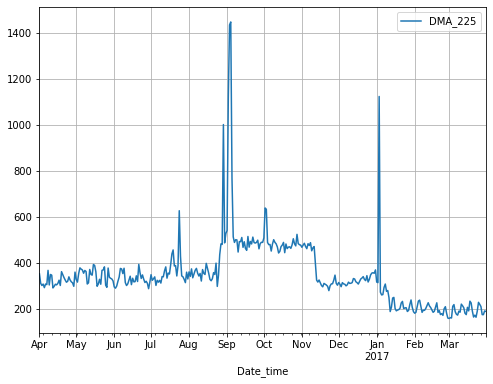

<Figure size 1584x720 with 0 Axes>

In [ ]:
# Looking at plots
DMA225_df_indexed = daily_data[['DMA_225']]
DMA225_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [ ]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(daily_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.812360
p-value: 0.056530
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Observation :

1.The ADF statistic value of -2. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).



In [ ]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(daily_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



(0.6356467832598806,
 0.019395746976374494,
 17,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 0.63. The positive value is statistic, and hence we have a stationary dataset

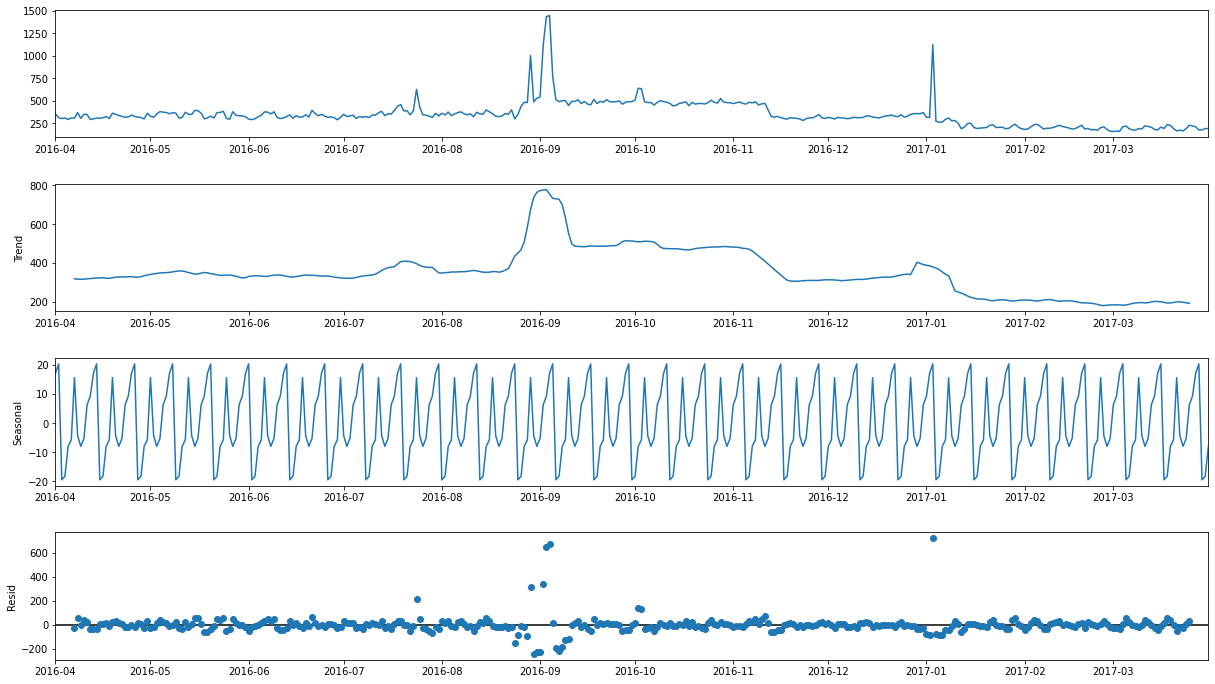

In [ ]:
res=sm.tsa.seasonal_decompose(daily_data,period=12)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

Baseline model : Persistence model

In [ ]:
# Making a df
Original = daily_data["DMA_225"].to_frame().rename(columns = {"DMA_225": "Original" })
Forecast  = daily_data["DMA_225"].to_frame().shift(1).rename(columns = {"DMA_225": "Forecast" })
baseline = pd.concat([Original,Forecast],axis=1)
final = baseline[1:]#there is no prediction for first row due to shifting.
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(final.Original, final.Forecast))
rmse = round(rmse, 3)
print (" The root mean square value on dataset: ",rmse)

 The root mean square value on dataset:  94.632


<Figure size 1584x720 with 0 Axes>

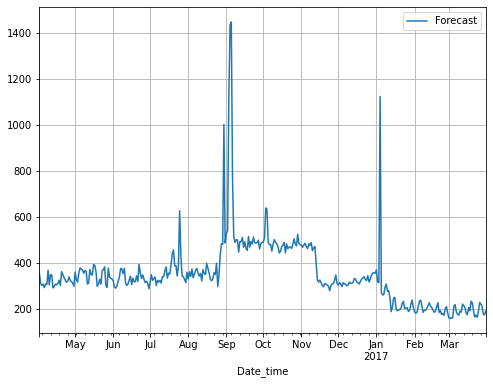

<Figure size 1584x720 with 0 Axes>

In [ ]:
baseline_model = final[['Forecast']]
baseline_model.plot(grid=True)
plt.figure(figsize=(22,10))

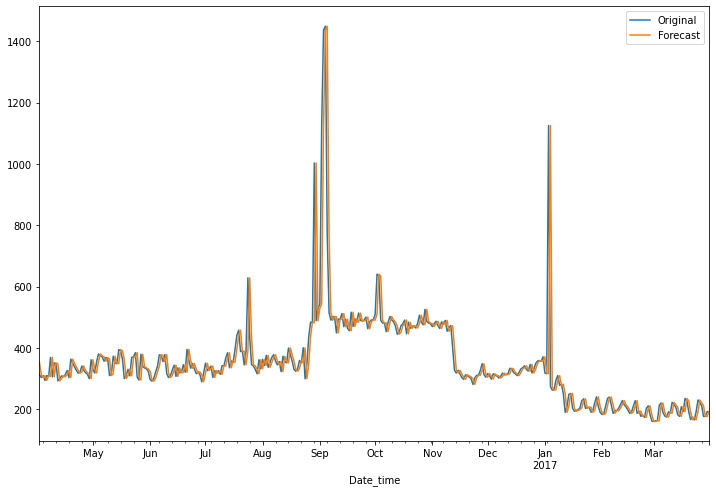

In [ ]:
final.plot(figsize=(12,8))

 The root mean square value on dataset using baseline model:  125.565


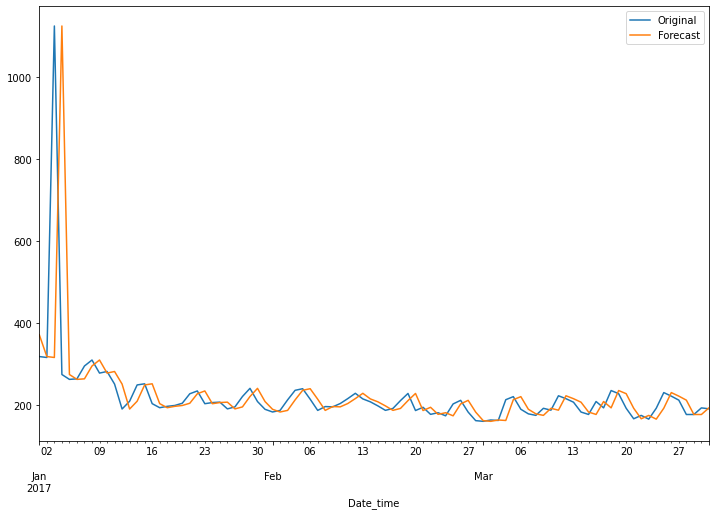

In [ ]:
baseline_graph = final[-90:]
rmse1 = np.sqrt(mean_squared_error(baseline_graph.Original, baseline_graph.Forecast))
rmse1 = round(rmse1, 3)
print (" The root mean square value on dataset using baseline model: ",rmse1)
baseline_graph.plot(figsize=(12,8))

Sarimax with 12 grid search

In [8]:
train = daily_data[:-90]
test = daily_data[-90:]

In [9]:
# Getting best arima model 
p = d = q = range(0, 2)
pdq_cal = list(itertools.product(p, d, q))
# generation of different combinations of seasonal p, q and q triplets
pdq_seasonal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
aic_bestvalue = np.inf
pdq_bestvalue = None
pdq_seasonal_best = None
tempmodel = None
for params in pdq_cal:   
    for seasonal_params in pdq_seasonal: 
        tempmodel = SARIMAX(train['DMA_225'],order=params,seasonal_order = seasonal_params,enforce_invertibility=False,enforce_stationarity=False)
        results = tempmodel.fit(disp=False)
        if results.aic < aic_bestvalue:
            aic_bestvalue = results.aic
            pdq_bestvalue = params
            pdq_seasonal_best = seasonal_params
print("Best ARIMA with seasonality (SARIMAX) {} x {} model - AIC:{}".format(pdq_bestvalue,pdq_seasonal_best,aic_bestvalue))

Best ARIMA with seasonality (SARIMAX) (1, 1, 1) x (0, 1, 1, 12) model - AIC:2915.3853236187956


In [10]:
train.head(2)

,DMA_225
Date_time,
2016-04-01,354.219001
2016-04-02,313.328000


In [11]:
test.head(2)

,DMA_225
Date_time,
2017-01-01,318.552999
2017-01-02,316.326001


In [13]:
test.tail(2)

,DMA_225
Date_time,
2017-03-30,193.332001
2017-03-31,191.109001


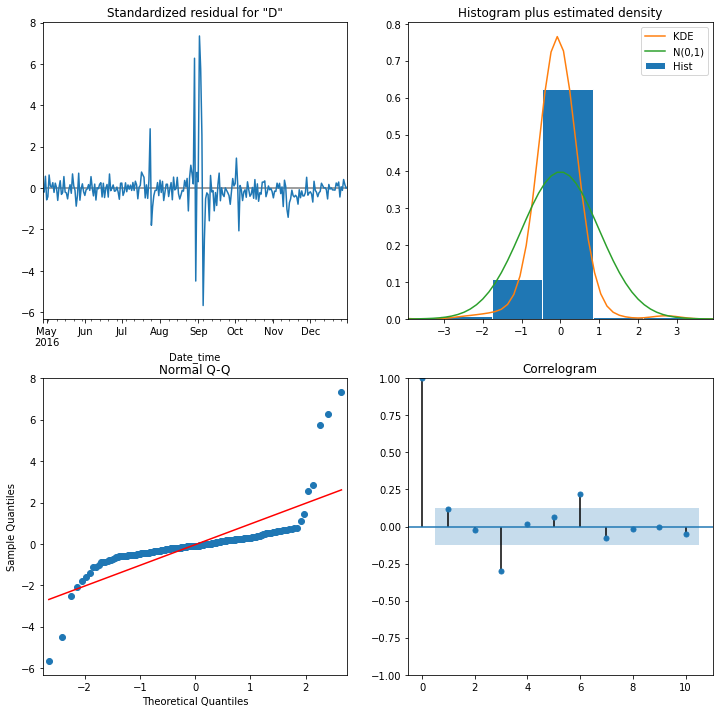

In [23]:
# Training the model on the full dataset and predict last 24 hours output
model =  SARIMAX(train,order = (1, 1, 1), 
                        seasonal_order =(0, 1, 1, 12),enforce_invertibility=False,
                             enforce_stationarity=False)
sarimax = model.fit()
sarimax.plot_diagnostics(figsize=(12, 12))
plt.show()

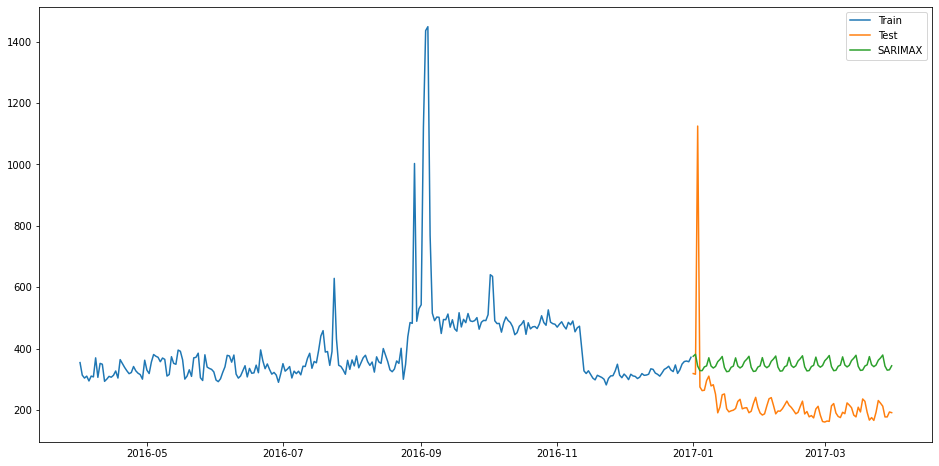

In [14]:
final = test.copy()
final['SARIMAX'] = sarimax.predict(start="2017-01-01", end="2017-03-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['DMA_225'], label='Train')
plt.plot(test['DMA_225'], label='Test')
plt.plot(final['SARIMAX'], label='SARIMAX')
plt.legend(loc='best')
plt.show()

In [15]:
testset = test.reset_index()
fd=pd.merge(testset, final.SARIMAX, on="Date_time")
fd

,Date_time,DMA_225,SARIMAX
0,2017-01-01,318.552999,374.790260
1,2017-01-02,316.326001,381.272277
2,2017-01-03,1124.990000,342.934192
3,2017-01-04,274.774000,328.037217
4,2017-01-05,262.884000,328.045640
...,...,...,...
85,2017-03-27,212.222000,378.936222
86,2017-03-28,177.217999,342.844916
87,2017-03-29,177.221000,329.576153
88,2017-03-30,193.332001,330.764522


In [17]:
# Calculate rmse of original and predicted value
rmse = np.sqrt(mean_squared_error(fd.DMA_225,fd.SARIMAX))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  164.717


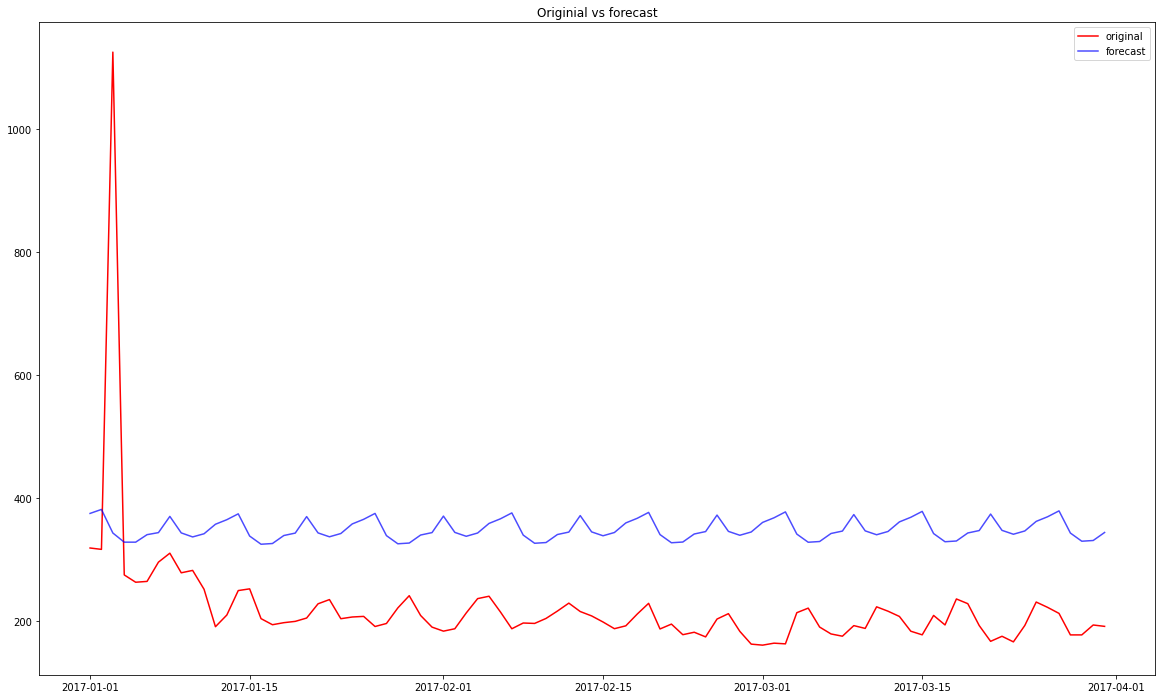

In [18]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd.Date_time, fd.DMA_225, color='red', label='original')
plt.plot(fd.Date_time, fd.SARIMAX, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

# LSTM

In [ ]:
dd = daily_data.values
train_size = int(len(dd)-90)
train_data = dd[:train_size]
test_data = dd[train_size:]


In [ ]:
train_data.shape

(275, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [ ]:
def matrix_dataset(array_dataset, timesteps=1):
 mat_X, mat_Y = [], []
 for i in range(len(array_dataset)-timesteps-1):
  Z = i+timesteps
  m = array_dataset[i:Z, 0]
  mat_X.append(m)
  n = array_dataset[Z, 0]
  mat_Y.append(n)
 return np.array(mat_X), np.array( mat_Y)


look_back = 27
features = 1
X_train1, Y_train1 = matrix_dataset(train_scaled, look_back)
X_test1, Y_test1 = matrix_dataset(test_scaled, look_back)

In [ ]:
X_train1 = X_train1.reshape((X_train1.shape[0],X_train1.shape[1],1))
X_test1 = X_test1.reshape( (X_test1.shape[0],X_test1.shape[1],1))

In [ ]:
X_train1.shape

(247, 27, 1)

In [ ]:
# Define the LSTM network
model = Sequential()
model.add(LSTM(100,input_shape=(27, 1)))
model.add(Dropout(0.4))
model.add(Dense(60))
# model.add(Dropout(0.3))
model.add(Dense(31))
model.compile(loss='mean_absolute_error', optimizer='adam')
y=model.fit(X_train1,Y_train1, epochs=200, batch_size=2,verbose=1, shuffle=False ,validation_data=(X_test1,Y_test1))

Epoch 1/200
124/124 [==============================] - 4s 17ms/step - loss: 0.0453 - val_loss: 0.0197
Epoch 2/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0483 - val_loss: 0.0206
Epoch 3/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0473 - val_loss: 0.0196
Epoch 4/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0465 - val_loss: 0.0215
Epoch 5/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0452 - val_loss: 0.0206
Epoch 6/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0437 - val_loss: 0.0202
Epoch 7/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0423 - val_loss: 0.0189
Epoch 8/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0417 - val_loss: 0.0181
Epoch 9/200
124/124 [==============================] - 2s 14ms/step - loss: 0.0412 - val_loss: 0.0191
Epoch 10/200
124/124 [==============================] - 2s 14ms/step - loss: 0.039

In [ ]:

# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(y.history['loss'])
    plt.plot(y.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

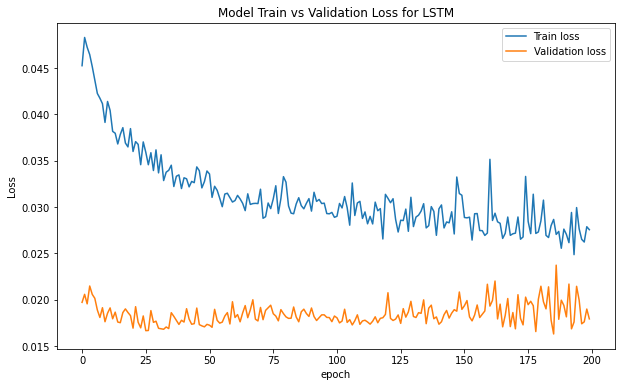

In [ ]:
plot_loss(y,'LSTM')

In [ ]:
# Generate predictions
train_pred = model.predict(X_train1)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.predict(X_test1)

In [ ]:
# De-standardising the output to original value
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([Y_train1])
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([Y_test1])
predictions = test_pred

In [ ]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0]))
final_data = pd.DataFrame((y_test[0]))
#final_data = pd.DataFrame((Y_test))
final_data.rename(columns = {0:'original_value'}, inplace = True)
final_data['predicted_value'] = lstm_df

In [ ]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_data['original_value'], final_data['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  21.772750214968465


In [ ]:
final_df2= daily_data.reset_index()
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(X_test1)]
y = [y for y in Y_test1]
# Creating the frame to store both predictions
days = final_df2[['Date_time']].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_data], axis=1, join='inner')

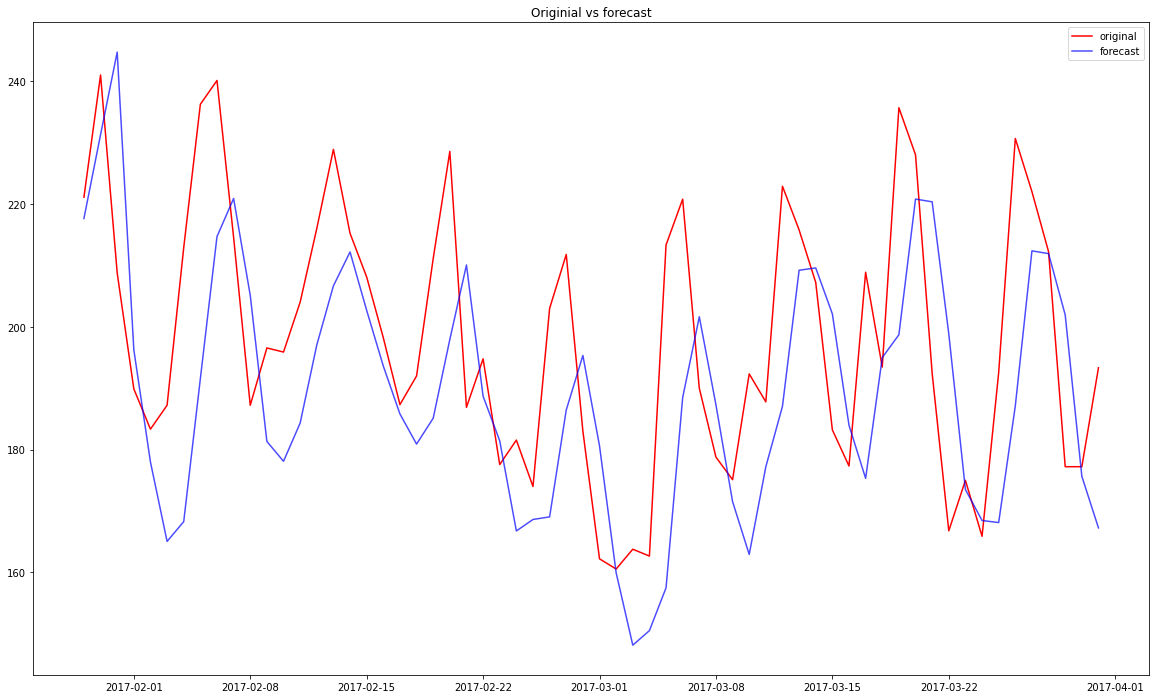

In [ ]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

sarimax 24 gour grid search

In [19]:
# One month prediction:
trainset = daily_data[:-90]
testset = daily_data[-90:]

In [21]:
# Getting best arima model 
p = d = q = range(0, 2)
pdq_cal = list(itertools.product(p, d, q))
# generation of different combinations of seasonal p, q and q triplets
pdq_seasonal = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
aic_bestvalue = np.inf
pdq_bestvalue = None
pdq_seasonal_best = None
tempmodel = None
for params in pdq_cal:   
    for seasonal_params in pdq_seasonal: 
        tempmodel = SARIMAX(trainset['DMA_225'],order=params,seasonal_order = seasonal_params,enforce_invertibility=False,enforce_stationarity=False)
        results = tempmodel.fit(disp=False)
        if results.aic < aic_bestvalue:
            aic_bestvalue = results.aic
            pdq_bestvalue = params
            pdq_seasonal_best = seasonal_params
print("Best ARIMA with seasonality (SARIMAX) {} x {} model - AIC:{}".format(pdq_bestvalue,pdq_seasonal_best,aic_bestvalue))

Best ARIMA with seasonality (SARIMAX) (1, 1, 1) x (0, 1, 1, 24) model - AIC:2663.6155246086932


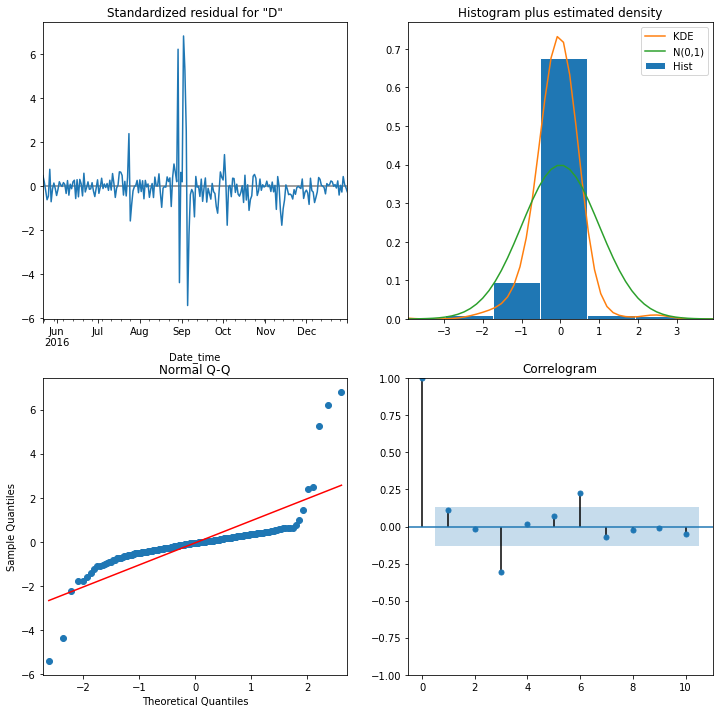

In [22]:
# Training the model on the full dataset and predict last 24 hours output
model =  SARIMAX(trainset,order = (1, 1, 1), 
                        seasonal_order =(0, 1, 1, 24),enforce_invertibility=False,
                             enforce_stationarity=False)
sarimax_mdl = model.fit()
sarimax_mdl.plot_diagnostics(figsize=(12, 12))
plt.show()

In [24]:
testset

,DMA_225
Date_time,
2017-01-01,318.552999
2017-01-02,316.326001
2017-01-03,1124.990000
2017-01-04,274.774000
2017-01-05,262.884000
...,...
2017-03-27,212.222000
2017-03-28,177.217999
2017-03-29,177.221000


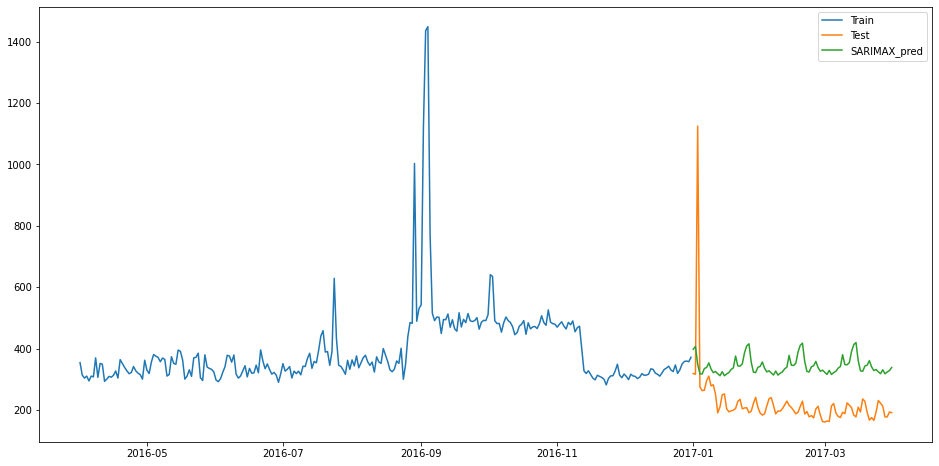

In [27]:
final_df = testset.copy()
final_df['SARIMAX_pred'] = sarimax_mdl.predict(start="2017-01-01",end='2017-03-31', dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( trainset['DMA_225'], label='Train')
plt.plot(testset['DMA_225'], label='Test')
plt.plot(final_df['SARIMAX_pred'], label='SARIMAX_pred')
plt.legend(loc='best')
plt.show()

In [28]:
test_df = testset.reset_index()
fd_df=pd.merge(test_df, final_df.SARIMAX_pred, on="Date_time")
fd_df

,Date_time,DMA_225,SARIMAX_pred
0,2017-01-01,318.552999,397.577232
1,2017-01-02,316.326001,406.836168
2,2017-01-03,1124.990000,349.414444
3,2017-01-04,274.774000,317.737037
4,2017-01-05,262.884000,317.198822
...,...,...,...
85,2017-03-27,212.222000,330.935490
86,2017-03-28,177.217999,317.723173
87,2017-03-29,177.221000,323.714264
88,2017-03-30,193.332001,328.199820


In [30]:
# Calculate rmse of original and predicted value
rmse = np.sqrt(mean_squared_error(fd_df.DMA_225,fd_df.SARIMAX_pred))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  161.183


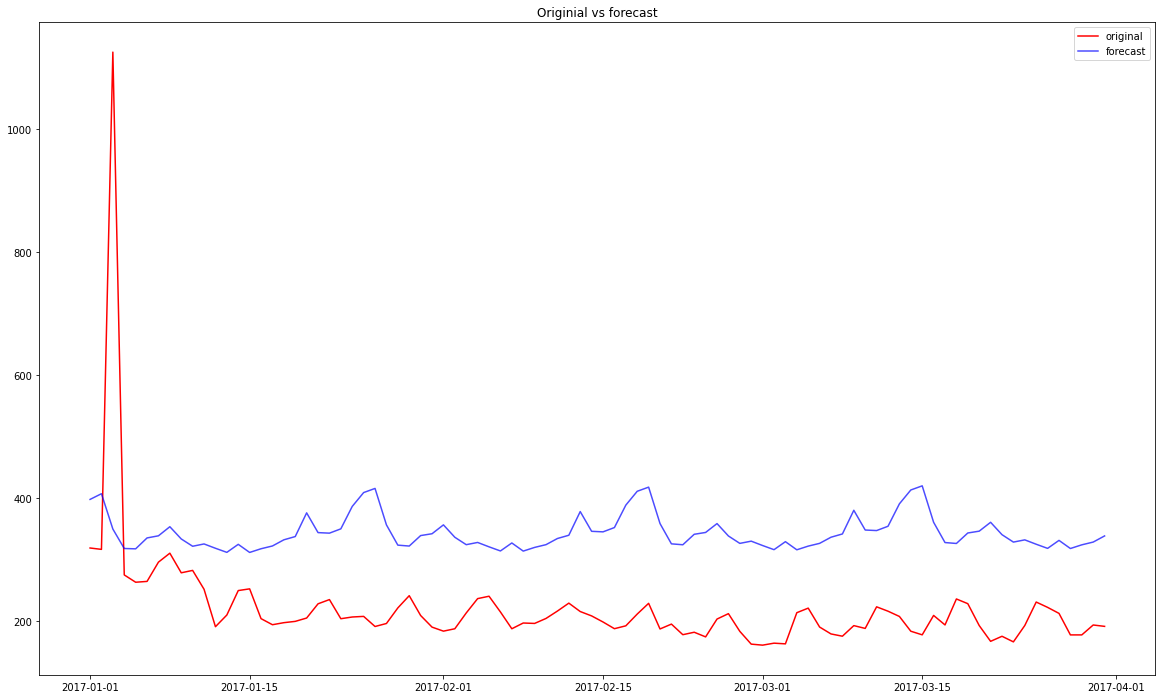

In [32]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd_df.Date_time, fd_df.DMA_225, color='red', label='original')
plt.plot(fd_df.Date_time, fd_df.SARIMAX_pred, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()